In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.causal_graph import *
from config import *
from train import *
import figures.plot as plot
from util import memory_recall_probe, feedforward_probe, activation_probe
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=2, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [2]:
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed, pos_enc, mlp_layer):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layer == 0:
        mlp = (True,False)
    else:
        mlp = (False, True)
    
    config = Config(
            emb_dim=32,
            num_layers=2,
            num_heads=(1,1),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=40000,
            eval_iter=1000,
            pos_enc=pos_enc,
            get_attn=50,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=32,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-3,
            task_name="frm"
        )
    
    sampler_config = MarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, batch_size=BATCH_SIZE, rho=rho, alpha=alpha, fixed=fixed, order=1,
                                         task_name="frm")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=True)

    return train_results, model

## RPE: MLP on First Layer

Random rows: tensor([1], device='cuda:0')
Layer: 0


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

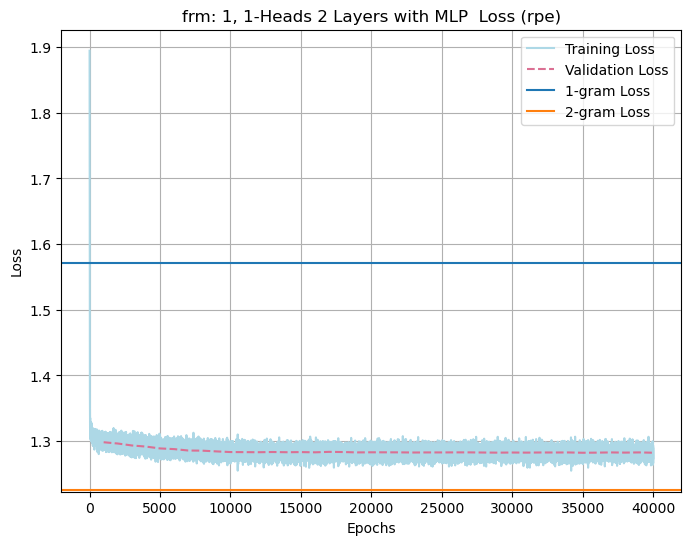

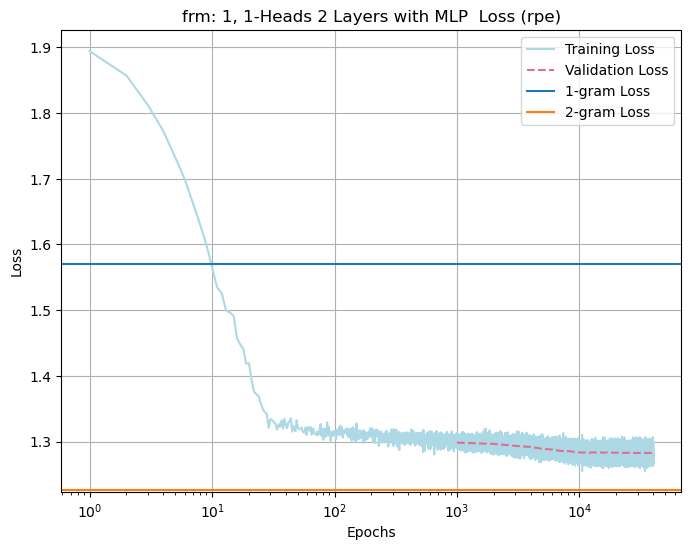

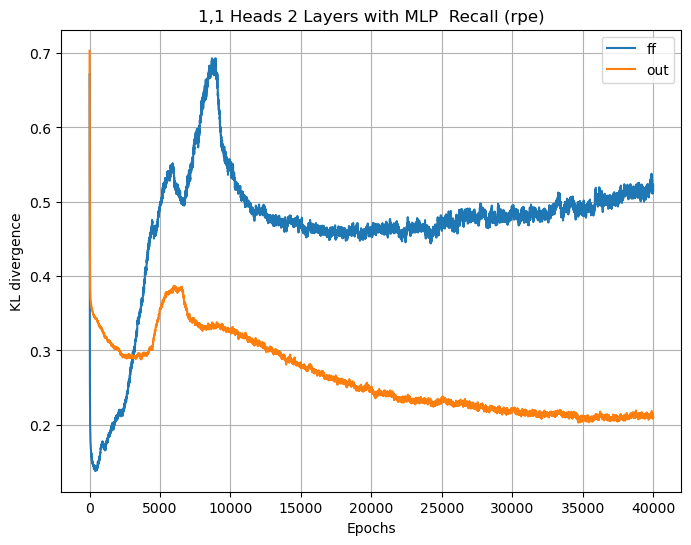

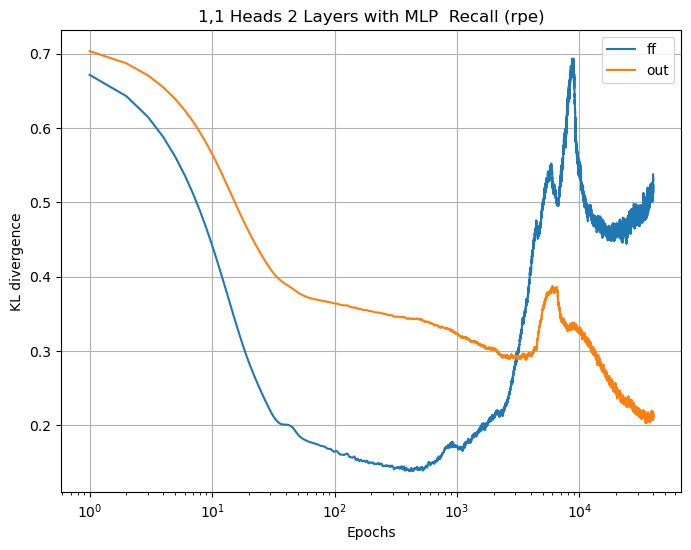

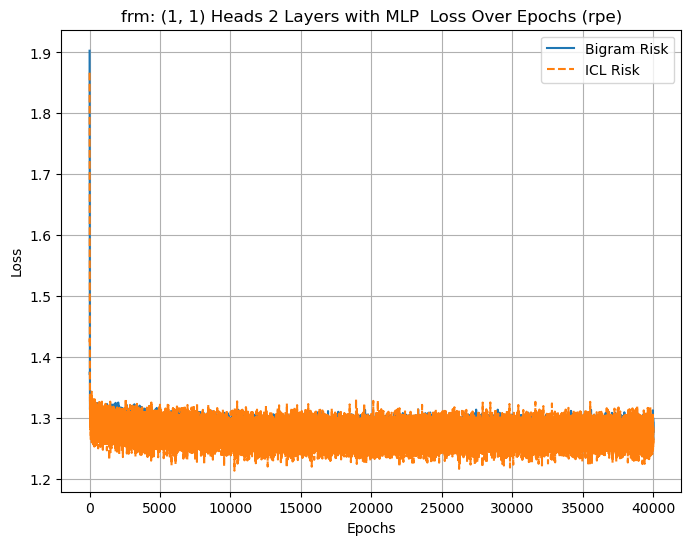

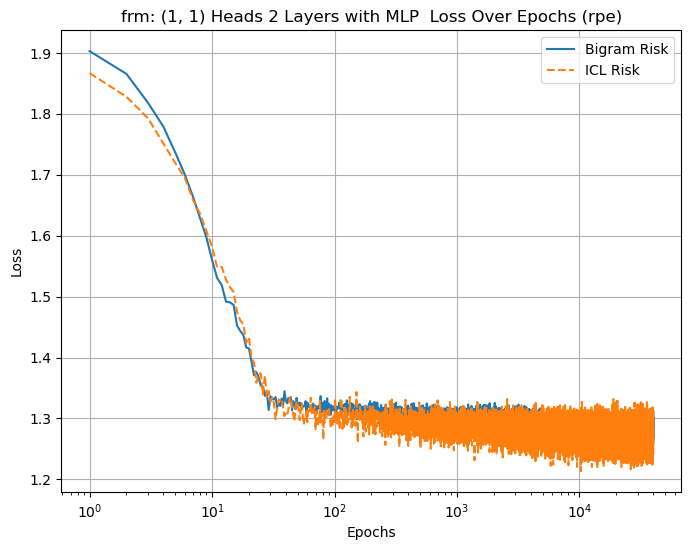

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [45]:
SEQ_LEN = 50
VOC_SIZE = 5
BATCH_SIZE = 256
rho = 0.2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=0)

### Check Memorization for RPE

In [46]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.21, 0.01, 0.19, 0.49, 0.09], device='cuda:0')

In [47]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[0].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.21, 0.06, 0.06, 0.05, 0.04], device='cuda:0', grad_fn=<AbsBackward0>)

In [48]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.35, 0.05, 0.01, 0.42, 0.17]]], device='cuda:0')


tensor([[0.01, 0.00, 0.01, 0.00, 0.00],
        [0.01, 0.00, 0.01, 0.00, 0.00],
        [0.01, 0.00, 0.01, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [53]:
batch, mask = train_results["sampler"].test()

tensor([[[0.18, 0.15, 0.05, 0.38, 0.24]]], device='cuda:0')


In [54]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.21, 0.20, 0.19, 0.20],
        [0.17, 0.17, 0.18, 0.31, 0.17],
        [0.15, 0.12, 0.17, 0.40, 0.15],
        [0.11, 0.11, 0.14, 0.50, 0.13],
        [0.11, 0.11, 0.13, 0.41, 0.23],
        [0.10, 0.11, 0.12, 0.48, 0.20],
        [0.09, 0.10, 0.10, 0.54, 0.17],
        [0.07, 0.09, 0.09, 0.59, 0.15],
        [0.07, 0.09, 0.09, 0.61, 0.14],
        [0.07, 0.09, 0.08, 0.65, 0.12]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## RPE: MLP on Second Layer

Random rows: tensor([1], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

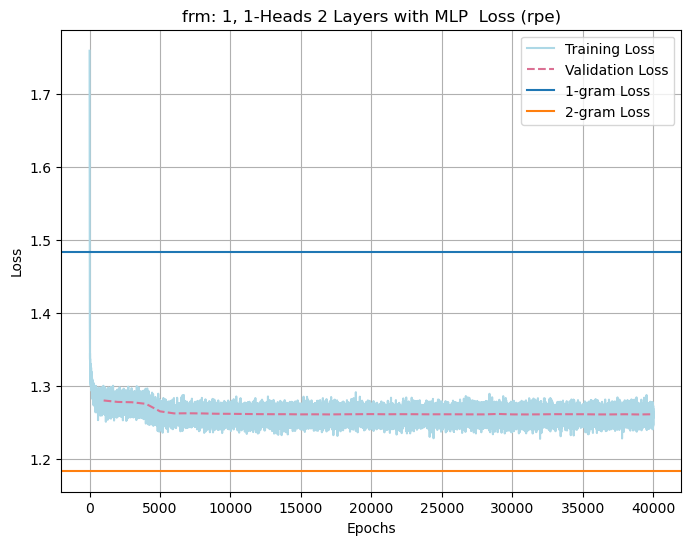

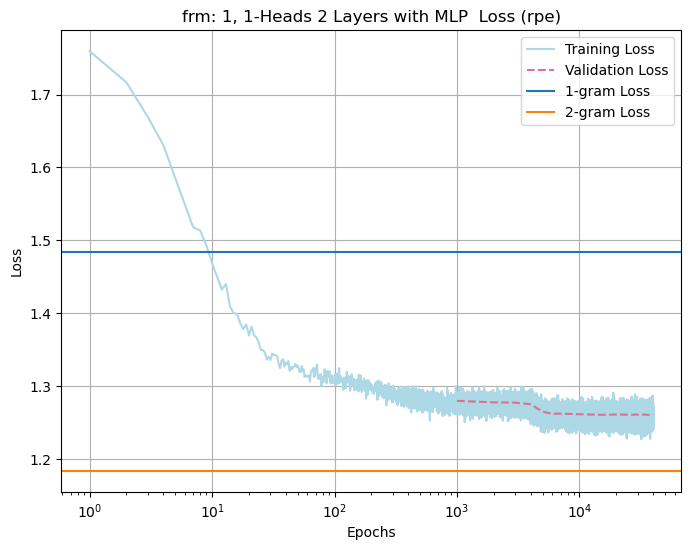

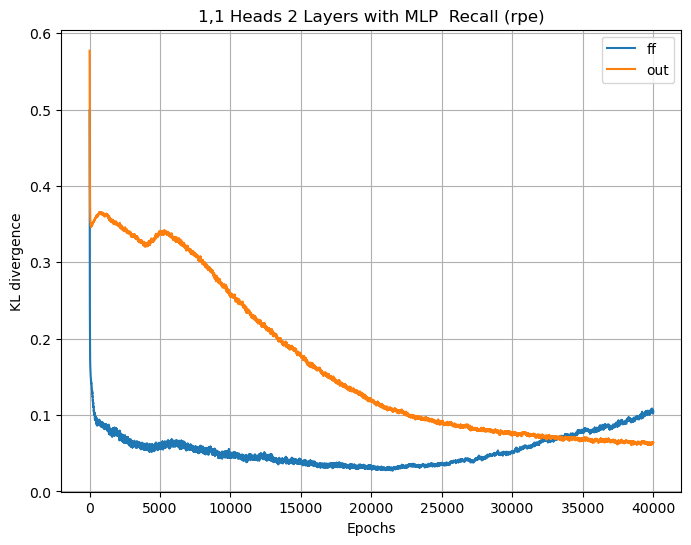

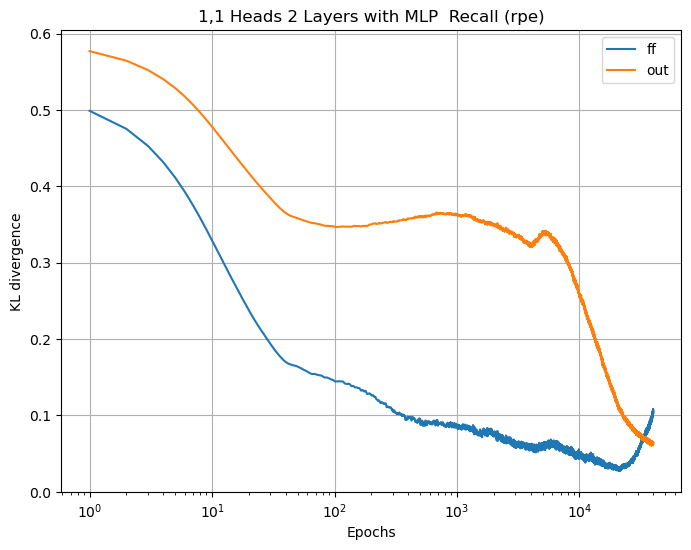

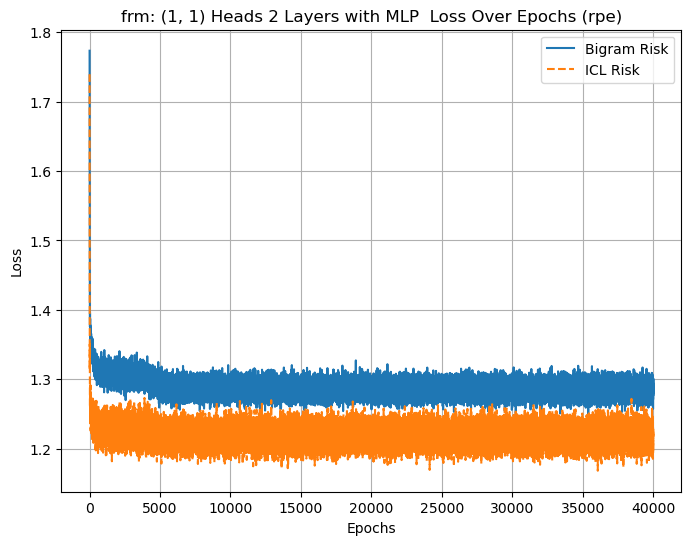

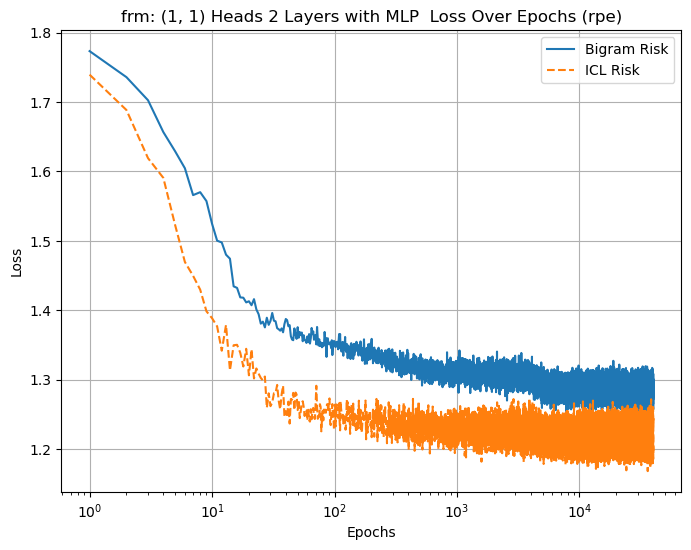

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [57]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=1)

### Check Memorization for RPE

In [58]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.10, 0.55, 0.11, 0.17, 0.08], device='cuda:0')

In [59]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.04, 0.02, 0.03, 0.01, 0.02], device='cuda:0', grad_fn=<AbsBackward0>)

In [60]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.25, 0.17, 0.34, 0.09, 0.14]]], device='cuda:0')


tensor([[0.00, 0.01, 0.00, 0.00, 0.00],
        [0.00, 0.01, 0.00, 0.00, 0.00],
        [0.00, 0.01, 0.00, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [61]:
batch, mask = train_results["sampler"].test()

tensor([[[0.23, 0.07, 0.46, 0.07, 0.17]]], device='cuda:0')


In [62]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.20, 0.19, 0.20, 0.20],
        [0.16, 0.18, 0.32, 0.17, 0.17],
        [0.14, 0.16, 0.43, 0.14, 0.14],
        [0.13, 0.13, 0.36, 0.13, 0.25],
        [0.11, 0.12, 0.43, 0.11, 0.22],
        [0.11, 0.10, 0.39, 0.11, 0.30],
        [0.10, 0.08, 0.44, 0.10, 0.28],
        [0.09, 0.08, 0.49, 0.10, 0.25],
        [0.08, 0.15, 0.45, 0.09, 0.23],
        [0.08, 0.14, 0.49, 0.08, 0.21],
        [0.07, 0.11, 0.53, 0.08, 0.20],
        [0.07, 0.18, 0.49, 0.07, 0.19],
        [0.07, 0.18, 0.51, 0.07, 0.18],
        [0.06, 0.16, 0.54, 0.07, 0.17],
        [0.11, 0.14, 0.52, 0.06, 0.16],
        [0.15, 0.12, 0.51, 0.06, 0.16],
        [0.15, 0.11, 0.53, 0.06, 0.15],
        [0.19, 0.10, 0.51, 0.06, 0.14],
        [0.18, 0.10, 0.48, 0.05, 0.18],
        [0.22, 0.09, 0.46, 0.05, 0.17]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## RPE: MLP on Second Layer

Random rows: tensor([4], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

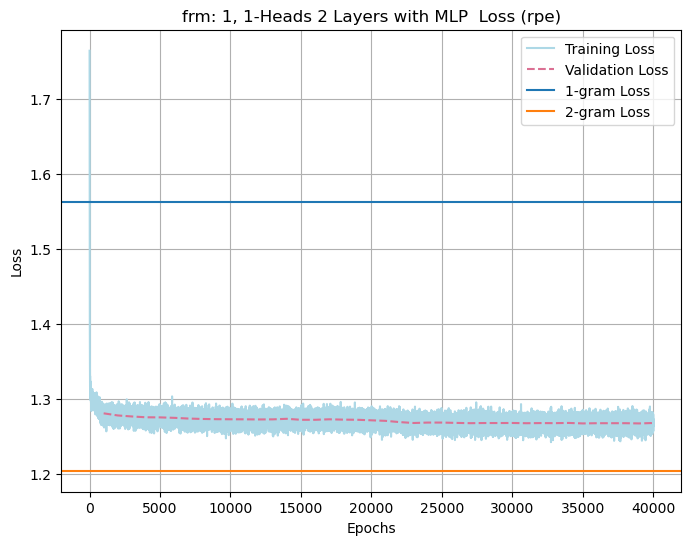

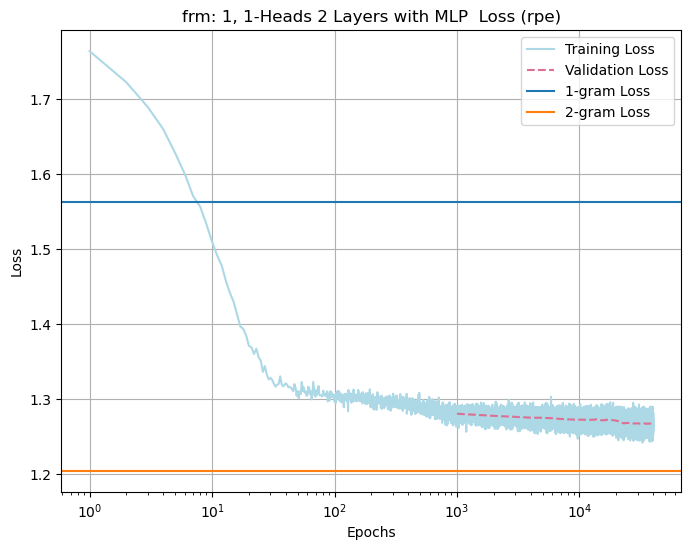

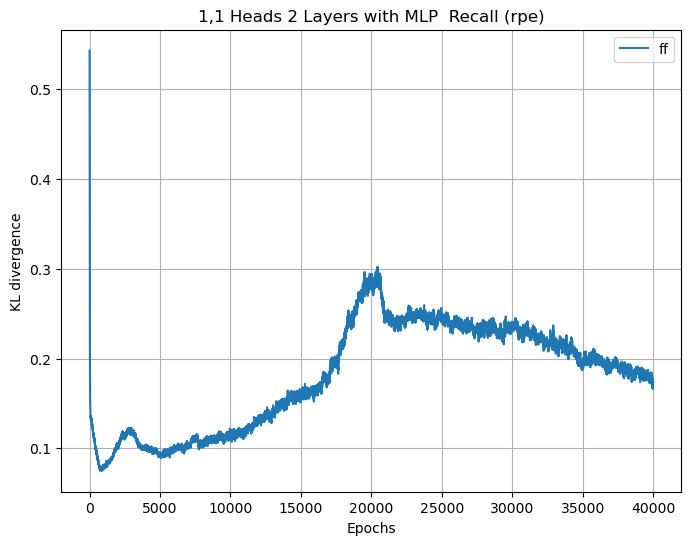

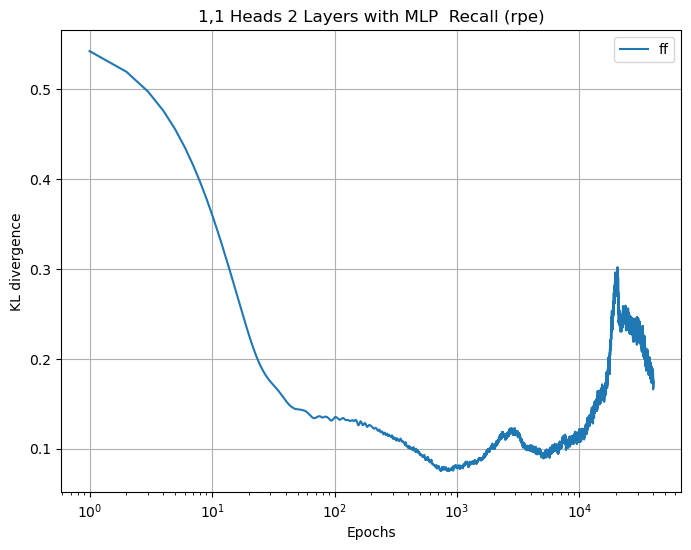

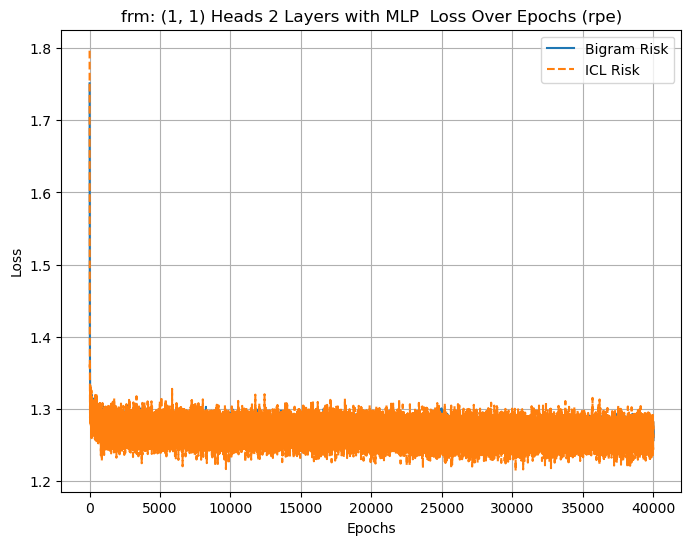

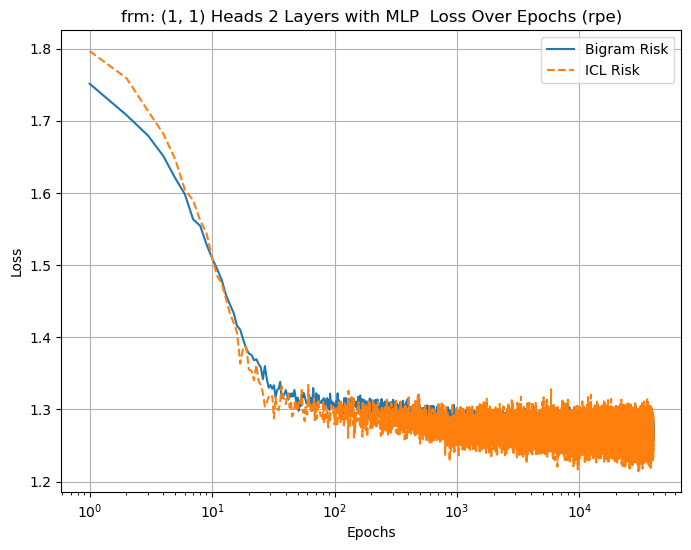

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [3]:
SEQ_LEN = 50
VOC_SIZE = 5
BATCH_SIZE = 256
rho = 0.2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rpe", mlp_layer=1)

### Check Memorization for RPE

In [4]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.03, 0.05, 0.40, 0.01, 0.51], device='cuda:0')

In [5]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.01, 0.01, 0.03, 0.01, 0.02], device='cuda:0', grad_fn=<AbsBackward0>)

In [6]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.43, 0.15, 0.04, 0.12, 0.26]]], device='cuda:0')


tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.01,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for RPE

In [7]:
batch, mask = train_results["sampler"].test()

tensor([[[0.03, 0.23, 0.29, 0.29, 0.17]]], device='cuda:0')


In [8]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.20, 0.19, 0.19, 0.21, 0.20],
        [0.17, 0.16, 0.15, 0.17, 0.35],
        [0.14, 0.14, 0.14, 0.28, 0.29],
        [0.13, 0.13, 0.23, 0.25, 0.26],
        [0.12, 0.11, 0.31, 0.22, 0.24],
        [0.11, 0.11, 0.28, 0.21, 0.30],
        [0.09, 0.10, 0.32, 0.18, 0.30],
        [0.08, 0.09, 0.29, 0.26, 0.28],
        [0.08, 0.08, 0.35, 0.24, 0.25],
        [0.08, 0.07, 0.39, 0.22, 0.24],
        [0.07, 0.07, 0.36, 0.27, 0.22],
        [0.06, 0.13, 0.34, 0.26, 0.20],
        [0.06, 0.12, 0.32, 0.30, 0.19]], device='cuda:0',
       grad_fn=<IndexBackward0>)

## Rotary: MLP on Second Layer

Random rows: tensor([2], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

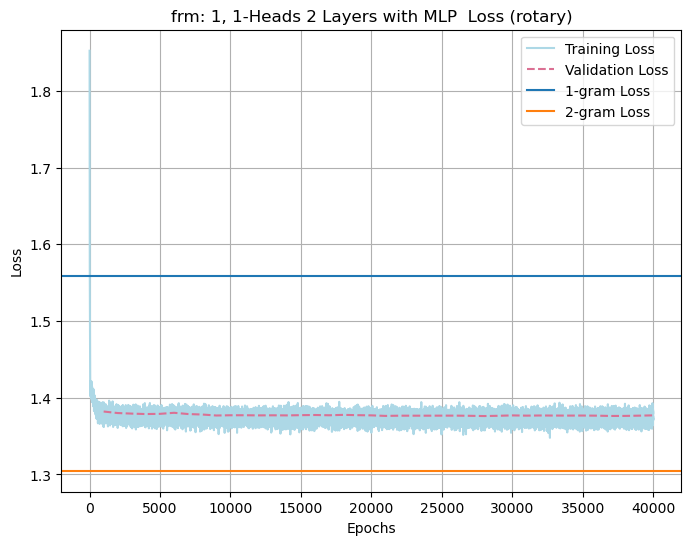

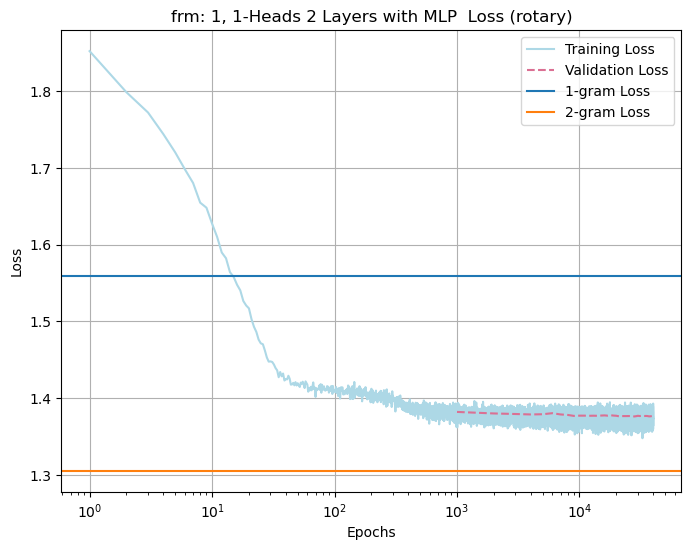

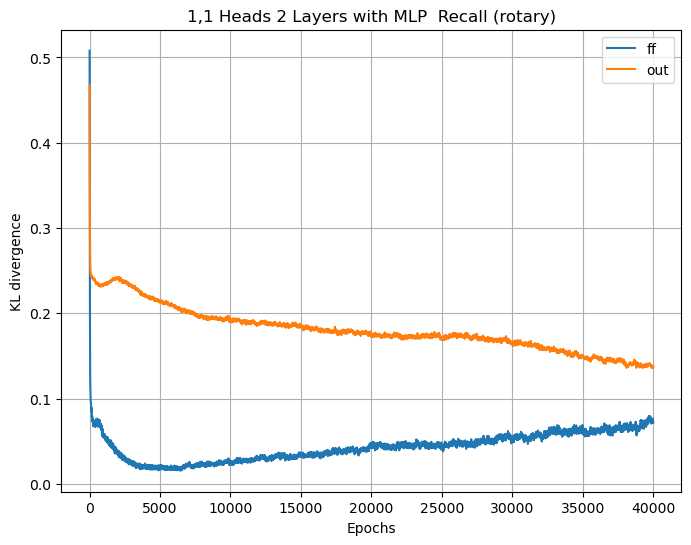

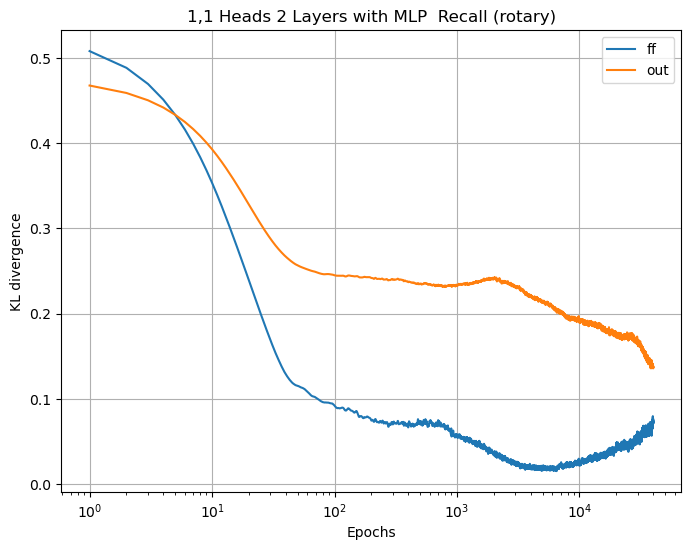

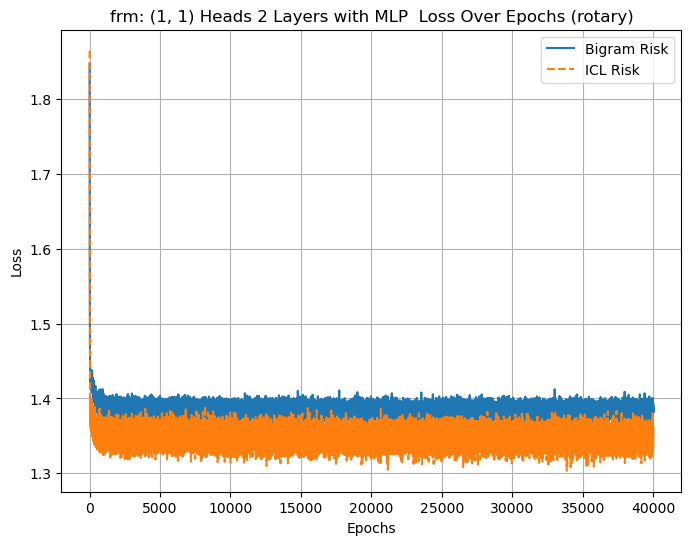

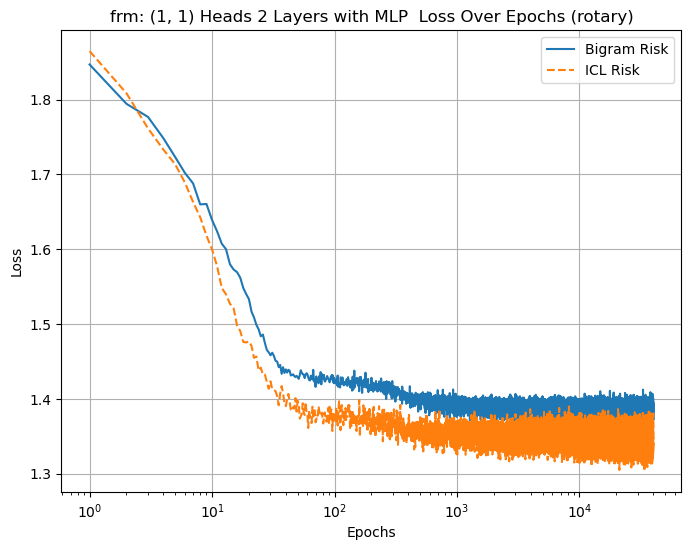

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [63]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rotary", mlp_layer=1)

### Check Memorization for Rotary

In [64]:
train_results["sampler"].base_trans_matrix[0]

tensor([0.06, 0.29, 0.27, 0.02, 0.36], device='cuda:0')

In [65]:
toks = model.embed(torch.tensor([0], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.03, 0.00, 0.06, 0.01, 0.07], device='cuda:0', grad_fn=<AbsBackward0>)

In [66]:
batch, mask = train_results["sampler"].test()
(nn.Softmax(-1)(model(batch)[0])[batch==0][-3:] - train_results["sampler"].base_trans_matrix[0].unsqueeze(0)).abs()

tensor([[[0.31, 0.09, 0.13, 0.31, 0.16]]], device='cuda:0')


tensor([[0.00, 0.00, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.01, 0.00, 0.01],
        [0.00, 0.00, 0.00, 0.00, 0.00]], device='cuda:0',
       grad_fn=<AbsBackward0>)

### Check Generalization for Rotary

In [69]:
batch, mask = train_results["sampler"].test()
batch, mask

tensor([[[0.11, 0.29, 0.20, 0.04, 0.36]]], device='cuda:0')


(tensor([[1, 0, 4, 0, 4, 4, 2, 4, 4, 2, 1, 2, 4, 1, 0, 2, 4, 4, 1, 1, 0, 1, 2, 0,
          2, 4, 0, 4, 0, 4, 0, 4, 1, 2, 2, 2, 4, 2, 4, 4, 0, 2, 1, 3, 1, 1, 2, 1,
          3, 2]], device='cuda:0'),
 tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
          1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
          0, 0]], device='cuda:0'))

In [ ]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

## Rotary: MLP on Second Layer

Random rows: tensor([0], device='cuda:0')
Layer: 1


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

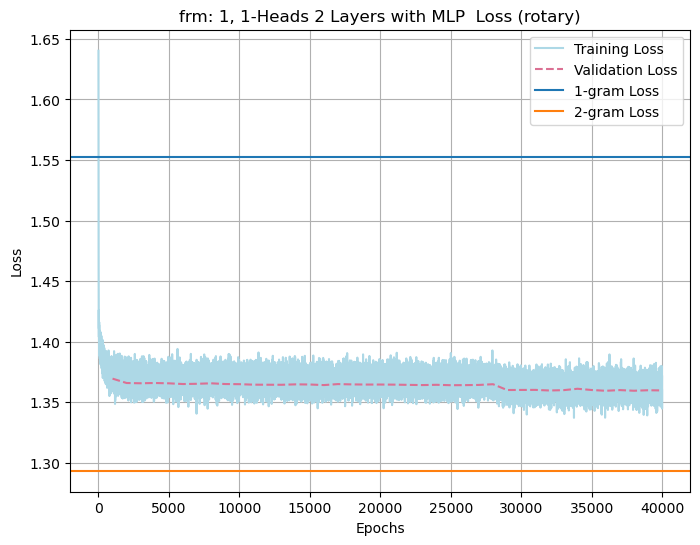

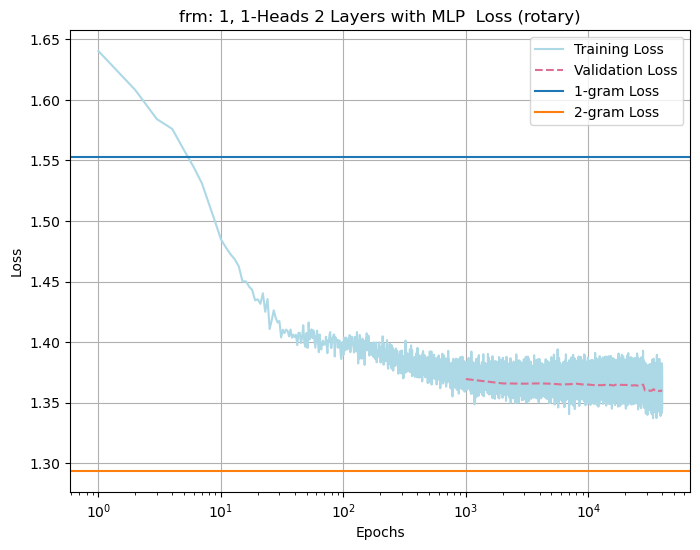

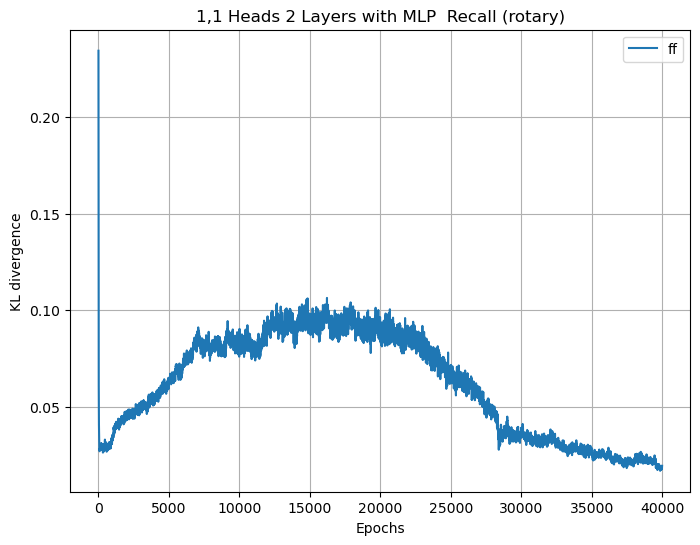

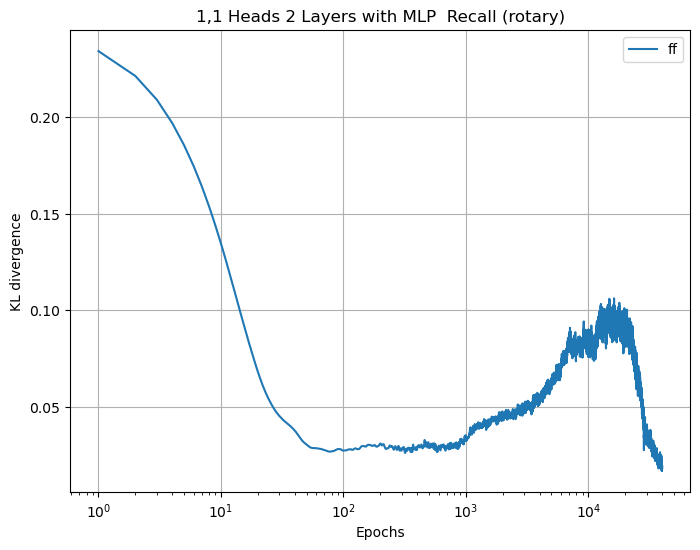

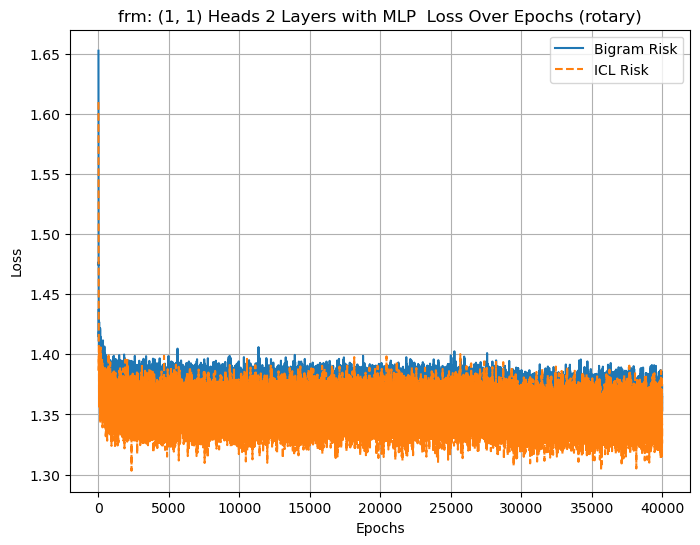

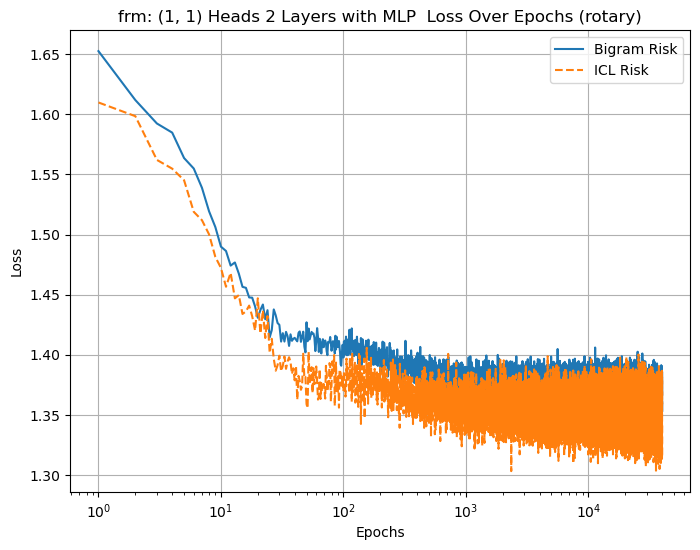

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

Creating images:   0%|          | 0/800 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [9]:
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, rho, alpha, fixed=True, pos_enc="rotary", mlp_layer=1)

### Check Memorization for Rotary

In [15]:
train_results["sampler"].base_trans_matrix[1]

tensor([0.51, 0.06, 0.10, 0.12, 0.20], device='cuda:0')

In [16]:
toks = model.embed(torch.tensor([1], device="cuda"))
mlp_out = model.layers[1].mlp(toks)
toks += mlp_out
toks = model.output_layer(toks)
probs = nn.Softmax(-1)(toks)
(probs.squeeze() - train_results["sampler"].base_trans_matrix[0]).abs()

tensor([0.26, 0.05, 0.19, 0.11, 0.22], device='cuda:0', grad_fn=<AbsBackward0>)

In [17]:
batch, mask = train_results["sampler"].test()
nn.Softmax(-1)(model(batch)[0])[batch==1][-3:]

tensor([[[0.09, 0.14, 0.04, 0.24, 0.50]]], device='cuda:0')


tensor([[0.52, 0.06, 0.10, 0.12, 0.20],
        [0.52, 0.06, 0.10, 0.12, 0.20],
        [0.52, 0.06, 0.10, 0.12, 0.20]], device='cuda:0',
       grad_fn=<SliceBackward0>)

### Check Generalization for Rotary

In [18]:
batch, mask = train_results["sampler"].test()
batch, mask

tensor([[[0.37, 0.04, 0.07, 0.37, 0.15]]], device='cuda:0')


(tensor([[0, 0, 3, 1, 0, 0, 3, 4, 1, 0, 3, 4, 1, 0, 3, 0, 0, 0, 2, 1, 1, 3, 2, 1,
          3, 1, 0, 3, 1, 1, 0, 2, 3, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0,
          0, 4]], device='cuda:0'),
 tensor([[1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
          0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
          1, 0]], device='cuda:0'))

In [19]:
nn.Softmax(-1)(model(batch)[0].squeeze())[mask[0]==1]

tensor([[0.27, 0.19, 0.19, 0.18, 0.18],
        [0.27, 0.19, 0.19, 0.18, 0.18],
        [0.28, 0.14, 0.14, 0.31, 0.14],
        [0.36, 0.12, 0.13, 0.26, 0.12],
        [0.34, 0.11, 0.11, 0.35, 0.10],
        [0.29, 0.10, 0.10, 0.42, 0.10],
        [0.26, 0.09, 0.09, 0.48, 0.09],
        [0.34, 0.08, 0.08, 0.41, 0.08],
        [0.40, 0.08, 0.08, 0.37, 0.08],
        [0.35, 0.07, 0.14, 0.38, 0.06],
        [0.31, 0.07, 0.13, 0.43, 0.06],
        [0.30, 0.07, 0.18, 0.39, 0.06],
        [0.28, 0.06, 0.17, 0.43, 0.06],
        [0.33, 0.06, 0.16, 0.40, 0.06],
        [0.37, 0.06, 0.15, 0.37, 0.05],
        [0.40, 0.05, 0.14, 0.35, 0.05],
        [0.42, 0.05, 0.14, 0.33, 0.05],
        [0.45, 0.05, 0.14, 0.32, 0.05],
        [0.47, 0.05, 0.13, 0.30, 0.05],
        [0.49, 0.05, 0.12, 0.29, 0.05],
        [0.52, 0.05, 0.11, 0.28, 0.04],
        [0.49, 0.04, 0.11, 0.31, 0.04],
        [0.51, 0.04, 0.11, 0.29, 0.04]], device='cuda:0',
       grad_fn=<IndexBackward0>)